# Importation des bibiliothèques

In [1]:
import os
import black

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno

from skimpy import skim

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    log_loss
)

import shap

c:\Users\lamou\Downloads\Projet_Scoring_Lamour_Christien_ABDELJALIL_KADASEDODE\Projet_Scoring_ToExport\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importation des données

In [2]:
data_train = pd.read_csv("data/data_train.csv")
data_test = pd.read_csv("data/data_test.csv")

In [3]:
print(data_train.columns)
print(data_test.columns)

Index(['BAD', 'LOAN', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'CLNO', 'DEBTINC', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe',
       'JOB_Sales', 'JOB_Self', 'REASON_HomeImp'],
      dtype='object')
Index(['BAD', 'LOAN', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'CLNO', 'DEBTINC', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe',
       'JOB_Sales', 'JOB_Self', 'REASON_HomeImp'],
      dtype='object')


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4171 entries, 0 to 4170
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BAD             4171 non-null   int64  
 1   LOAN            4171 non-null   int64  
 2   VALUE           4171 non-null   float64
 3   YOJ             4171 non-null   float64
 4   DEROG           4171 non-null   int64  
 5   DELINQ          4171 non-null   int64  
 6   CLAGE           4171 non-null   float64
 7   NINQ            4171 non-null   int64  
 8   CLNO            4171 non-null   int64  
 9   DEBTINC         4171 non-null   float64
 10  JOB_Office      4171 non-null   float64
 11  JOB_Other       4171 non-null   float64
 12  JOB_ProfExe     4171 non-null   float64
 13  JOB_Sales       4171 non-null   float64
 14  JOB_Self        4171 non-null   float64
 15  REASON_HomeImp  4171 non-null   float64
dtypes: float64(10), int64(6)
memory usage: 521.5 KB


* Séparation des variables explicatives dans chaques ensembles

In [5]:
X_train = data_train.drop(columns=['BAD'])
y_train = data_train['BAD']

X_test = data_test.drop(columns=['BAD'])
y_test = data_test['BAD']

# Sélection des Variables avec SelectKBest

f_classif analyse si les moyennes des différentes classes de la variable cible ( BAD = 0et BAD = 1) sont significativement différentes en fonction des valeurs des variables explicatives. Cela permet d'identifier quelles variables sont les plus discriminantes à prédire BAD.

In [6]:
# Appliquer SelectKBest avec f_classif pour obtenir les scores F et les p-values
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train, y_train)

# Extraire les scores et les p-values
scores = selector.scores_
pvalues = selector.pvalues_

# dataframe pour afficher les résultats
feature_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'F-Score': scores,
    'p-Value': pvalues
})
feature_scores_sorted = feature_scores.sort_values(by='F-Score', ascending=False)  # Trier les variables par score décroissant

feature_scores['p-Value'] = feature_scores['p-Value'].apply(lambda x: '{:.4f}'.format(x))

feature_scores_sorted = feature_scores.sort_values(by='F-Score', ascending=False) # Trier les variables par ordre décroissant de F-Score

# Afficher le dataframe trié
feature_scores_sorted

,Feature,F-Score,p-Value
4,DELINQ,506.028365,0.0000
3,DEROG,278.415310,0.0000
6,NINQ,131.157636,0.0000
5,CLAGE,112.017145,0.0000
8,DEBTINC,101.104215,0.0000
0,LOAN,29.267935,0.0000
2,YOJ,18.055318,0.0000
9,JOB_Office,15.763889,0.0001
1,VALUE,11.379004,0.0007
11,JOB_ProfExe,7.062117,0.0079


DELINQ et DEROG sont les variables les plus significatives avec des F-scores très élevés (506,03 et 278,42) et des p-values ​​extrêmement faibles, indiquant une forte capacité à discriminer entre les classes de la variable cible BAD.

NINQ , CLAGE , et DEBTINC suivent également avec des F-scores élevés, confirmant leur importance dans la modélisation de BAD.

Des variables comme LOAN , YOJ , et JOB_Office ont également des scores relativement élevés, mais moins significatifs par rapport aux variables les plus importantes.

In [7]:

# Sélection des variables à partir de SelectKBest basé sur les p-values ​​extrêmement faibles, 
# indiquant une forte capacité à discriminer entre les classes de la variable cible BAD.

selected_features = ['DELINQ','DEROG','NINQ','CLAGE','DEBTINC','LOAN','YOJ','JOB_Office','VALUE','JOB_ProfExe','JOB_Other','JOB_Sales'] #  


X_train = X_train[selected_features]
X_test = X_test[selected_features]

# 1 /  Modélisation Random Forest (Forêt Aléatoire) 

 Nous avons tester 3 modele : 
 
 - un sans optimisation 
 - le deuxieme avec optimisation des seuils pratiques 
 - le dernier un modele optimisé avec grid search

 et par la suite regarder  comment evoluent nos métriques en fonction du nombre de variables
 cela nous a permi de faire un modele final avec le bon bon nombre de variable.

* 1/ Random forest Sans optimisation

* 1A / Creation et entrainement du modele de foret aléatoire

In [8]:

# oob_score=True : C'est une façon d'obtenir une évaluation du modèle sans avoir à utiliser un jeu de validation explicite.
random_forest1 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=99, class_weight='balanced',oob_score=True)
random_forest1.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, oob_score=True,
                       random_state=99)

* 1B / Prediction sur la base d'apprentissage et la base de test

In [9]:

# Predire les classes sur les ensembles d'entrainement et de test

y_train_pred = random_forest1.predict(X_train)
y_test_pred = random_forest1.predict(X_test)

* 1C / Evaluation des performances du modele

In [10]:

# Calculer des mesures de performance pour l'ensemble d'entraînement
train_accuracy = accuracy_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, pos_label=1)
train_f1 = f1_score(y_train, y_train_pred, pos_label=1)

# Calculer des mesures de performance pour l'ensemble de test
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, pos_label=1)
test_f1 = f1_score(y_test, y_test_pred, pos_label=1)

# le tableau d'évaluation des performances avec précision et F1-score
performance_table1 = pd.DataFrame({
    'Métrique': ['Accuracy', 'AUC', 'Recall', 'Precision', 'F1-Score'],
    'Ensemble d\'entraînement': [train_accuracy, train_auc, train_recall, train_precision, train_f1],
    'Ensemble de test': [test_accuracy, test_auc, test_recall, test_precision, test_f1]
})

# le tableau d'évaluation des performances
print(performance_table1)

    Métrique  Ensemble d'entraînement  Ensemble de test
0   Accuracy                 0.951570          0.893736
1        AUC                 0.941285          0.831651
2     Recall                 0.924188          0.728291
3  Precision                 0.846748          0.736544
4   F1-Score                 0.883774          0.732394


Précision (train : 95.16%, test : 89.37%) : Le modèle a une très bonne performance en précision, mais il y a un écart modéré entre l'ensemble d'entraînement et l'ensemble de test, ce qui pourrait indiquer une certaine perte de généralisation sur des données non vues.

AUC (train : 94.13%, test : 83.16%) : L'AUC, qui mesure la capacité du modèle à différencier les classes, est bonne mais il y a une différence notable entre l'entraînement et le test, ce qui confirme une légère tendance à l'overfitting .

Rappel (train : 92,42%, test : 72,83%) : Le rappel est élevé sur l'ensemble d'entraînement, mais tombe significativement sur le test. Cela indique que le modèle raté des cas positifs dans l'ensemble de test (classe minoritaire, effectivement la classe BAD = 1).

* 1D / Regardons la courbe roc

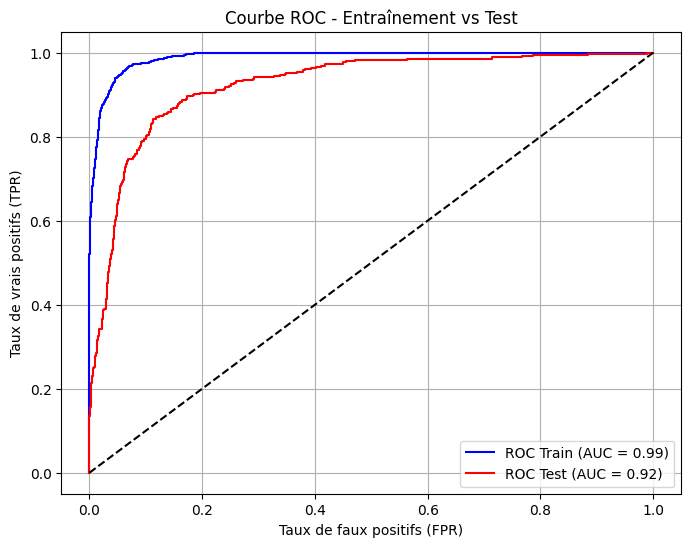

In [11]:


# Obtenir les scores de probabilité pour les classes positives
y_train_prob = random_forest1.predict_proba(X_train)[:, 1]
y_test_prob = random_forest1.predict_proba(X_test)[:, 1]

# Calculer les taux de faux positifs (FPR) et les taux de vrais positifs (TPR)
train_fpr, train_tpr, _ = roc_curve(y_train, y_train_prob)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_prob)
# Calculer les AUC pour l'entraînement et le test
train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

# Tracer les courbes ROC avec les AUC dans la légende
plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, color='blue', label=f'ROC Train (AUC = {train_auc:.2f})')
plt.plot(test_fpr, test_tpr, color='red', label=f'ROC Test (AUC = {test_auc:.2f})')

# Tracer la diagonale de référence
plt.plot([0, 1], [0, 1], 'k--')

# Ajouter des labels et un titre
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - Entraînement vs Test')

# Ajouter la légende
plt.legend()
plt.grid()
# Afficher le graphique
plt.show()

* 1E / Analyse de l'importance des variables 

Importance des variables :
       Variable  Importance
0       DEBTINC    0.382758
1         CLAGE    0.114565
2        DELINQ    0.113528
3         VALUE    0.100754
4          LOAN    0.089024
5           YOJ    0.063648
6         DEROG    0.053945
7          NINQ    0.048409
8    JOB_Office    0.012530
9     JOB_Other    0.010169
10  JOB_ProfExe    0.007175
11    JOB_Sales    0.003494



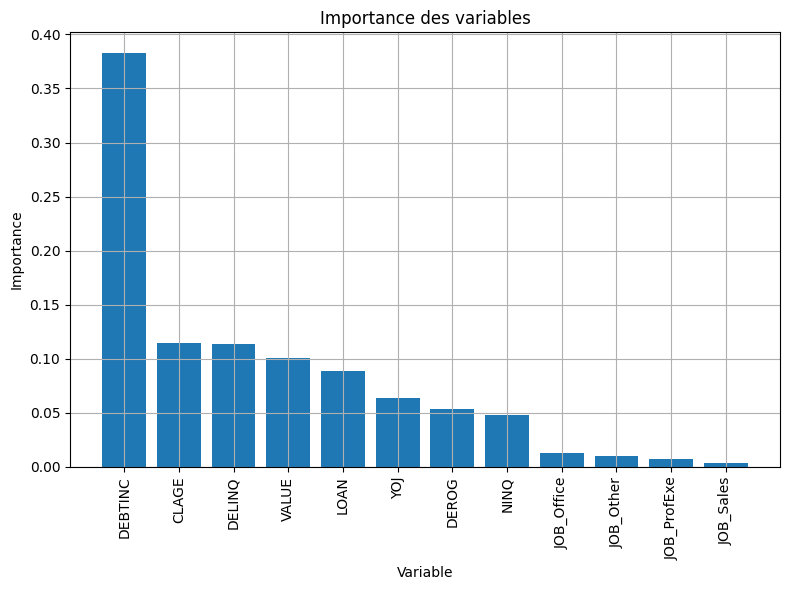

In [12]:
# Obtenir l'importance des variables
importance = random_forest1.feature_importances_

# Créer un DataFrame pour afficher l'importance des variables
importance_df = pd.DataFrame({'Variable': X_train.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Afficher l'importance des variables
print("Importance des variables :")
print(importance_df)
print()

# Tracer l'importance des variables
plt.figure(figsize=(8, 6))
plt.bar(importance_df['Variable'], importance_df['Importance'])
plt.xticks(rotation='vertical')
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.title('Importance des variables')
plt.tight_layout()
plt.grid()
plt.show()

Remarque : la varibles qui a le plus de poids à predire le defaut de paiement ou non est  le ration DEBTINC .
Ensuite il ya CLAGE ET DELINQ jusqua NING


* 1F / le log loss 1 

In [13]:

# Calculer le log loss sur les ensembles d'entraînement et de test
train_log_loss1 = log_loss(y_train, random_forest1.predict_proba(X_train)[:, 1])
test_log_loss1 = log_loss(y_test, random_forest1.predict_proba(X_test)[:, 1])

print(f'Log Loss - Entraînement: {train_log_loss1:.4f}')
print(f'Log Loss - Test: {test_log_loss1:.4f}')


Log Loss - Entraînement: 0.2104
Log Loss - Test: 0.3079


# 2 /  Modèle avec optimisation en utilisant les seuils pratique

 Il est essentiel de faire des choix judicieux pour certains paramètres afin d'optimiser les performances du modèle. 
 
 Deux paramètres importants que nous pouvons considérer sont :

max_features : Il s'agit qui est la complexité du modèle et d'éviter le surajustement (overfitting).

Pour ce faire , nous allons suivre une approche  consistant à fixer max_features à la racine carrée du nombre de variables utilisées. 

Cela permet de limiter la profondeur des arbres et de prévenir une croissance excessive, tout en maintenant un bon équilibre entre sous-apprentissage et surapprentissage.

* 2A /Entrainement du modèle

In [14]:
# Calculer DU nombre maximum de variables (max_features) à la racine carrée
max_features = int(np.sqrt(X_train.shape[1]))

# Créer la forêt aléatoire avec les hyperparamètres fixés
random_forest2 = RandomForestClassifier(n_estimators=100, max_depth=10, max_features=max_features, class_weight='balanced',oob_score=True)

# Entraîner le modèle sur les données d'entraînement
random_forest2.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=3,
                       oob_score=True)

* 2B /Prédiction sur les bases train et test

In [15]:
# Prédire les classes sur les ensembles d'entraînement et de test
y_train_pred = random_forest2.predict(X_train)
y_test_pred = random_forest2.predict(X_test)

* 2C /Evaluons les performances

In [16]:

# Calculer Des mesures de performance pour l'ensemble d'entraînement
train_accuracy = accuracy_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, pos_label=1)
train_f1 = f1_score(y_train, y_train_pred, pos_label=1)

# Calculer Des mesures de performance pour l'ensemble de test
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, pos_label=1)
test_f1 = f1_score(y_test, y_test_pred, pos_label=1)

# le tableau d'évaluation des performances avec précision et F1-score
performance_table2 = pd.DataFrame({
    'Métrique': ['Accuracy', 'AUC', 'Recall', 'Precision', 'F1-Score'],
    'Ensemble d\'entraînement': [train_accuracy, train_auc, train_recall, train_precision, train_f1],
    'Ensemble de test': [test_accuracy, test_auc, test_recall, test_precision, test_f1]
})

# tableau d'évaluation des performances
print(performance_table2)

    Métrique  Ensemble d'entraînement  Ensemble de test
0   Accuracy                 0.947734          0.887584
1        AUC                 0.938438          0.822552
2     Recall                 0.922984          0.714286
3  Precision                 0.832790          0.720339
4   F1-Score                 0.875571          0.717300


Précision (train : 95.28%, test : 89.26%) : Les résultats sont très similaires à ceux du modèle sans optimisation, ce qui suggère que l'ajustement du seuil n'a pas amélioré de manière significative l'exactitude globale.

AUC (train : 93.88%, test : 81.83%) : L'AUC est légèrement inférieure à celle du modèle sans optimisation, ce qui indique que l'ajustement du seuil a diminué la capacité du modèle à discriminer entre les classes .

Rappel (train : 91.57%, test : 69.47%) : Le rappel a également baissé par rapport au modèle sans optimisation, ce qui montre que le nouveau seuil pourrait ne pas être optimal pour capturer suffisamment de cas positifs dans l'ensemble de test. Cela pourrait être problématique si l'objectif est de maximiser la détection des classes positives (cas BAD = 1).



* 2D /Performances du modèle

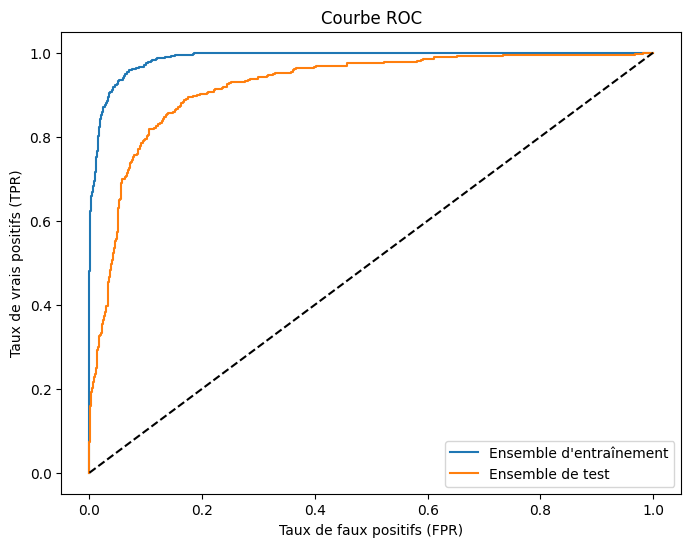

In [17]:
# Obtenir les scores de probabilité pour les classes positives
y_train_prob = random_forest2.predict_proba(X_train)[:, 1]
y_test_prob = random_forest2.predict_proba(X_test)[:, 1]

# Calculer les taux de faux positifs (FPR) et les taux de vrais positifs (TPR)
train_fpr, train_tpr, _ = roc_curve(y_train, y_train_prob)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_prob)

# Tracer les courbes ROC
plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, label='Ensemble d\'entraînement')
plt.plot(test_fpr, test_tpr, label='Ensemble de test')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend()
plt.show()

Remarque : 

On a 82% d'auc sur la base

* 2E /Importance des variables

Importance des variables :
       Variable  Importance
0       DEBTINC    0.404318
1         CLAGE    0.114863
2        DELINQ    0.103196
3         VALUE    0.093940
4          LOAN    0.089746
5           YOJ    0.058898
6         DEROG    0.055335
7          NINQ    0.047043
8    JOB_Office    0.012228
9     JOB_Other    0.008728
10  JOB_ProfExe    0.007586
11    JOB_Sales    0.004120



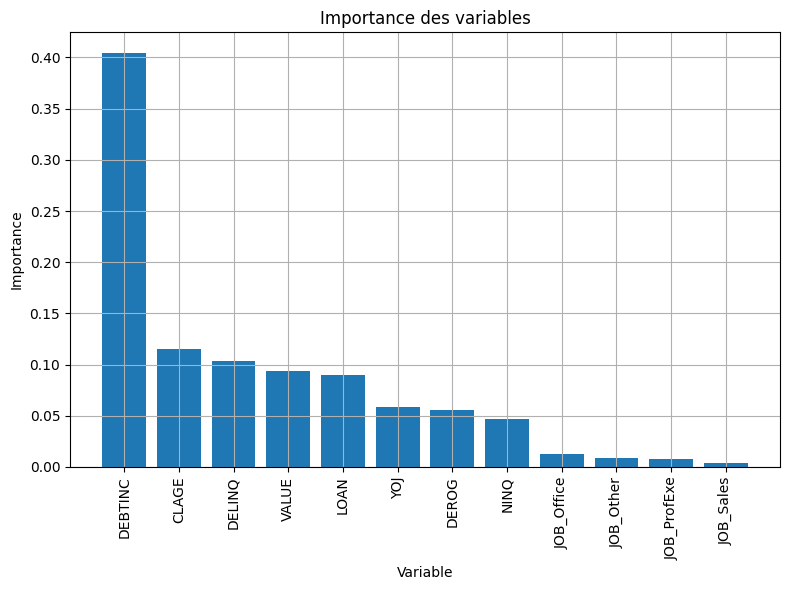

In [18]:
# Obtenir l'importance des variables
importance = random_forest2.feature_importances_

# Créer un DataFrame pour afficher l'importance des variables
importance_df = pd.DataFrame({'Variable': X_train.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Afficher l'importance des variables
print("Importance des variables :")
print(importance_df)
print()

# Tracer l'importance des variables
plt.figure(figsize=(8, 6))
plt.bar(importance_df['Variable'], importance_df['Importance'])
plt.xticks(rotation='vertical')
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.title('Importance des variables')
plt.tight_layout()
plt.grid()
plt.show()

* 2F / le log loss 2 

In [19]:
# Calculer le log loss sur les ensembles d'entraînement et de test
train_log_loss2 = log_loss(y_train, random_forest2.predict_proba(X_train)[:, 1])
test_log_loss2 = log_loss(y_test, random_forest2.predict_proba(X_test)[:, 1])

print(f'Log Loss - Entraînement: {train_log_loss2:.4f}')
print(f'Log Loss - Test: {test_log_loss2:.4f}')

Log Loss - Entraînement: 0.2069
Log Loss - Test: 0.3073


# 3 /  Optimisation avec une validation croisée , un grid search

Lors de cette optimisation les parametres que nous optimisont sont : 

n_estimators : nombre d'arbres de décision dans la forêt aléatoire. Augmenter ce nombre peut améliorer les performances du modèle, mais cela entraîne également une augmentation du temps de calcul.

max_depth : C'est la profondeur maximale de chaque arbre de décision. Une valeur plus élevée permet à l'arbre d'apprendre des relations plus complexes dans les données, mais elle peut également conduire à un surajustement. Il est important de trouver un équilibre pour éviter l'overfitting.

min_samples_split : Ce paramètre définit le nombre minimum d'échantillons requis pour scinder un nœud. Une valeur plus élevée peut conduire à des arbres plus simples et éviter l'overfitting, mais cela peut également entraîner une sous-représentation des informations dans les données.

* 3A /Entrainement du modèle

In [ ]:
# les hyperparamètres à tester à l'aide de GridSearch
param_grid = {
    'n_estimators': [100, 200, 300,500],
    'max_depth': [1,2,3,4,6,7,8]
}

# Modèle de forêt aléatoire
rf_model = RandomForestClassifier(oob_score=True, random_state=99)

# GridSearch pour trouver les meilleurs paramètres
grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres qui vont optimiser l'accuracy :", grid_search.best_params_)

# ['DELINQ','DEROG','NINQ','CLAGE','DEBTINC','LOAN','YOJ','JOB_Office','VALUE','JOB_ProfExe','JOB_Other','JOB_Sales']

In [21]:
# modèle de forêt aléatoire avec les meilleurs paramètres
random_forest3 = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'], max_depth=grid_search.best_params_['max_depth'], oob_score=True, random_state=99,class_weight='balanced')
# Entraîner le modèle sur les données d'entraînement
random_forest3.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, oob_score=True,
                       random_state=99)

Remarque : les meilleure  parametre qui vont optimiser l'accuracy sont 8 et 100

* 3B /Prédiction sur les bases train et test

In [22]:
# Prédire les classes sur les ensembles d'entraînement et de test
y_train_pred = random_forest3.predict(X_train)
y_test_pred = random_forest3.predict(X_test)

* 3C /Performance de la forêt aléatoire

In [23]:
# Calculer les mesures de performance pour l'ensemble d'entraînement
train_accuracy = accuracy_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, pos_label=1)
train_f1 = f1_score(y_train, y_train_pred, pos_label=1)

# Calculer les mesures de performance pour l'ensemble de test
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, pos_label=1)
test_f1 = f1_score(y_test, y_test_pred, pos_label=1)

# Créer le tableau d'évaluation des performances avec précision et F1-score
performance_table3 = pd.DataFrame({
    'Métrique': ['Accuracy', 'AUC', 'Recall', 'Precision', 'F1-Score'],
    'Ensemble d\'entraînement': [train_accuracy, train_auc, train_recall, train_precision, train_f1],
    'Ensemble de test': [test_accuracy, test_auc, test_recall, test_precision, test_f1]
})

# Afficher le tableau d'évaluation des performances
print(performance_table3)


    Métrique  Ensemble d'entraînement  Ensemble de test
0   Accuracy                 0.920643          0.884787
1        AUC                 0.906155          0.833418
2     Recall                 0.882070          0.747899
3  Precision                 0.758799          0.697128
4   F1-Score                 0.815804          0.721622


Précision (train : 92.06%, test : 88.48%) : Il y a une légère baisse de l'exactitude par rapport aux deux autres modèles, mais cet écart est plus petit entre l'entraînement et le test. Cela indique une meilleure généralisation du modèle optimisé sur des données non vues.

AUC (train : 90.62%, test : 83.34%) : L'AUC sur l'ensemble de test est légèrement supérieure à celle des deux autres modèles, ce qui montre une meilleure capacité de discrimination sur des données inconnues. L'AUC test est stable et proche de 83%, ce qui est encourageant.

Rappel (train : 88,21%, test : 74,79%) : Le rappel est aussi mieux équilibré que dans les deux autres modèles, en particulier sur l'ensemble de test. Le modèle optimisé détecte plus de cas positifs sans nuire excessivement à la performance globale.

* 3D /Performances du modèle

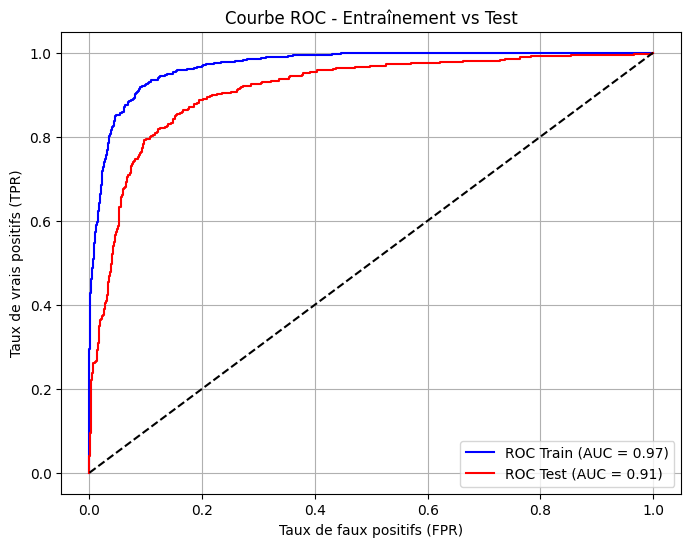

In [24]:
# Obtenir les scores de probabilité pour les classes positives
y_train_prob = random_forest3.predict_proba(X_train)[:, 1]
y_test_prob = random_forest3.predict_proba(X_test)[:, 1]

# Calculer les taux de faux positifs (FPR) et les taux de vrais positifs (TPR)
train_fpr, train_tpr, _ = roc_curve(y_train, y_train_prob)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_prob)

# Calculer les AUC pour l'entraînement et le test
train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

# Tracer les courbes ROC avec les AUC dans la légende
plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, color='blue', label=f'ROC Train (AUC = {train_auc:.2f})')
plt.plot(test_fpr, test_tpr, color='red', label=f'ROC Test (AUC = {test_auc:.2f})')

# Tracer la diagonale de référence
plt.plot([0, 1], [0, 1], 'k--')

# Ajouter des labels et un titre
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - Entraînement vs Test')

# Ajouter la légende
plt.legend()
plt.grid()
# Afficher le graphique
plt.show()

* 3E /Importance des variables

Importance des variables :
       Variable  Importance
0       DEBTINC    0.416608
1        DELINQ    0.126788
2         CLAGE    0.104996
3          LOAN    0.080655
4         VALUE    0.080017
5         DEROG    0.065086
6           YOJ    0.051931
7          NINQ    0.047383
8    JOB_Office    0.009483
9     JOB_Other    0.007336
10  JOB_ProfExe    0.005650
11    JOB_Sales    0.004067



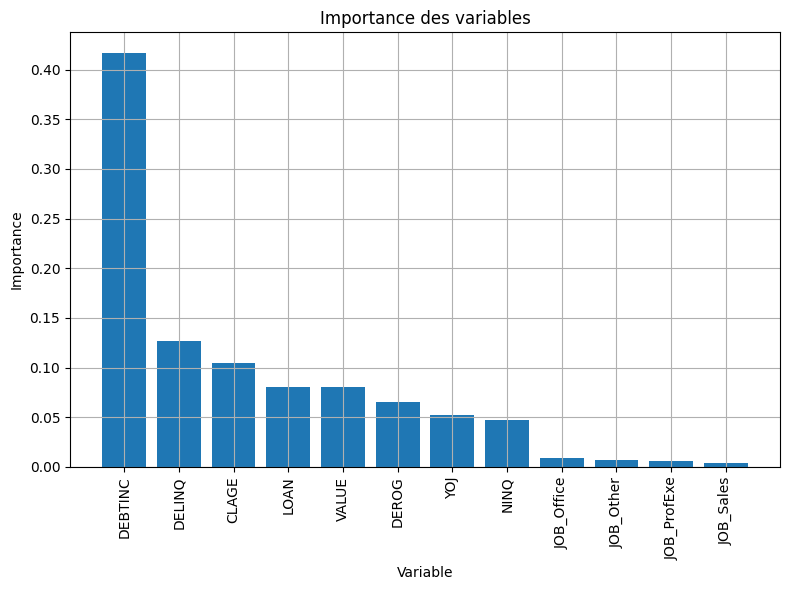

In [25]:
# Obtenir l'importance des variables
importance = random_forest3.feature_importances_

# Créer un DataFrame pour afficher l'importance des variables
importance_df = pd.DataFrame({'Variable': X_train.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Afficher l'importance des variables
print("Importance des variables :")
print(importance_df)
print()

# Tracer l'importance des variables
plt.figure(figsize=(8, 6))
plt.bar(importance_df['Variable'], importance_df['Importance'])
plt.xticks(rotation='vertical')
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.title('Importance des variables')
plt.tight_layout()
plt.grid()
plt.show()

In [26]:
print(performance_table1)
print(performance_table2)
print(performance_table3)

    Métrique  Ensemble d'entraînement  Ensemble de test
0   Accuracy                 0.951570          0.893736
1        AUC                 0.941285          0.831651
2     Recall                 0.924188          0.728291
3  Precision                 0.846748          0.736544
4   F1-Score                 0.883774          0.732394
    Métrique  Ensemble d'entraînement  Ensemble de test
0   Accuracy                 0.950372          0.889262
1        AUC                 0.935565          0.823600
2     Recall                 0.910951          0.714286
3  Precision                 0.850562          0.726496
4   F1-Score                 0.879721          0.720339
    Métrique  Ensemble d'entraînement  Ensemble de test
0   Accuracy                 0.920643          0.884787
1        AUC                 0.906155          0.833418
2     Recall                 0.882070          0.747899
3  Precision                 0.758799          0.697128
4   F1-Score                 0.815804          0

* 3F / le log loss 3 

In [27]:
# Calculer le log loss sur les ensembles d'entraînement et de test
train_log_loss3 = log_loss(y_train, random_forest3.predict_proba(X_train)[:, 1])
test_log_loss3 = log_loss(y_test, random_forest3.predict_proba(X_test)[:, 1])

print(f'Log Loss - Entraînement: {train_log_loss3:.4f}')
print(f'Log Loss - Test: {test_log_loss3:.4f}')


Log Loss - Entraînement: 0.2903
Log Loss - Test: 0.3540


# 4/ Comparaisons des performances des 3 modeles

* Comparaison des métriques

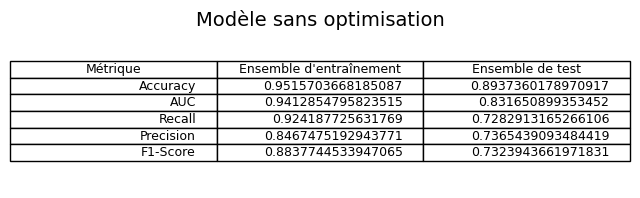

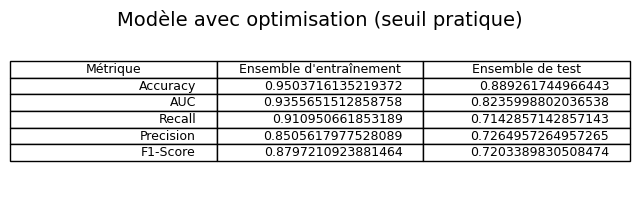

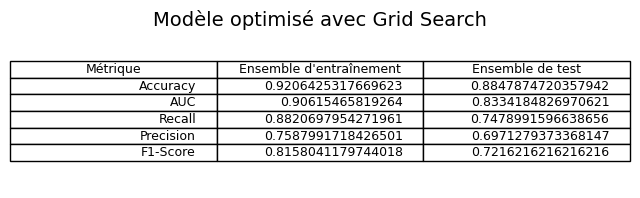

In [28]:
def display_table_with_matplotlib(table, title):
    fig, ax = plt.subplots(figsize=(8, 2))  # Ajuste la taille si nécessaire
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=table.values, colLabels=table.columns, loc='center')
    plt.title(title, fontsize=14)
    plt.show()

# Affichage des tableaux avec un titre
display_table_with_matplotlib(performance_table1, "Modèle sans optimisation")
display_table_with_matplotlib(performance_table2, "Modèle avec optimisation (seuil pratique)")
display_table_with_matplotlib(performance_table3, "Modèle optimisé avec Grid Search")


* Comparaison des log loss

In [29]:

print(f'Log Loss - Entraînement: {train_log_loss1:.4f}')
print(f'Log Loss - Test: {test_log_loss1:.4f}')

print(f'Log Loss - Entraînement: {train_log_loss2:.4f}')
print(f'Log Loss - Test: {test_log_loss2:.4f}')

print(f'Log Loss - Entraînement: {train_log_loss3:.4f}')
print(f'Log Loss - Test: {test_log_loss3:.4f}')


Log Loss - Entraînement: 0.2104
Log Loss - Test: 0.3079
Log Loss - Entraînement: 0.2087
Log Loss - Test: 0.3096
Log Loss - Entraînement: 0.2903
Log Loss - Test: 0.3540


* Analyse ,Interpretation des resultats  :

* Si on se base sur les métriques ,
Le choix du modèle dependra de l'objectif : maximiser le rappel ou maintenir un bon équilibre entre rappel et précision.

Modèle 1(sans optimisation) présente un bon équilibre entre rappel et précision, avec des performances élevées. Cependant, il montre un léger signe de surapprentissage , car les performances diminuent légèrement sur l'ensemble de test.

Modèle 2 (avec seuil pratique) est très similaire au modèle 1. Les performances sur l'ensemble de test sont légèrement inférieures à celles du modèle sans optimisation.

Modèle 3 (optimisé avec Grid Search) est optimisé pour un bon compromis entre rappel et précision. Il excelle dans la détection des classes positives ( BAD = 1), bien que la précision soit légèrement inférieure. Ce modèle semble mieux généraliser sur l'ensemble de test, ce qui est avantageux si l'objectif est de maximiser le rappel tout en maintenant des performances globales acceptables.

* Pour ce qui est des log loss,

Les modèles sans optimisation et avec seuil pratique ont des log loss plus faibles, ce qui indique une meilleure calibration des probabilités par rapport au modèle optimisé avec Grid Search. Ce dernier montre un écart plus important entre les ensembles d'entraînement et de test.


Le modèle avec seuil pratique présente le log loss le plus bas sur les deux ensembles, ce qui en fait le modèle le plus robuste en termes de qualité des probabilités prédites.

# 5/ Evolution des métriques avec le nombre de variables.

In [30]:
# Fonction pour entraîner et évaluer un modèle 
def evaluer_modele_avec_sous_ensembles(colonnes, model, x_train, x_test, y_train, y_test):
    # Initialisation des listes pour stocker les scores
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_scores = []

    # Boucle sur les tailles de sous-ensembles de colonnes
    for i in range(1, len(colonnes) + 1):
        # Sélectionner les premières 'i' colonnes
        subset_columns = colonnes[:i]
        x_train_subset = x_train[subset_columns]
        x_test_subset = x_test[subset_columns]

        # Entraîner le modèle
        model.fit(x_train_subset, y_train)

        # Prédictions et calcul des probabilités
        y_pred = model.predict(x_test_subset)
        y_pred_probs = model.predict_proba(x_test_subset)[:, 1]  # Probabilités pour ROC AUC

        # Calcul des métriques
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_probs)

        # Stocker les scores
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        auc_scores.append(auc)

    return precision_scores, recall_scores, f1_scores, auc_scores


# Liste des variables dans l'ordre d'importance (par exemple, celles que tu utilises déjà)
colonnes = [
    'DELINQ', 'DEROG', 'NINQ', 'CLAGE', 'DEBTINC', 'LOAN', 'YOJ',
    'JOB_Office', 'VALUE', 'JOB_ProfExe', 'JOB_Other'
]

# Entraîner et évaluer les 3 modèles
models = [random_forest1, random_forest2, random_forest3]  # Remplace par tes modèles
model_names = ['Modèle 1 (Sans Optimisation)', 'Modèle 2 (Seuil Pratique)', 'Modèle 3 (Grid Search)']

# Couleurs pour chaque modèle
colors = ['blue', 'green', 'red']

# Créer le graphique avec Plotly
fig = go.Figure()

# Pour chaque modèle
for i, model in enumerate(models):
    precision_scores, recall_scores, f1_scores, auc_scores = evaluer_modele_avec_sous_ensembles(
        colonnes, model, X_train, X_test, y_train, y_test
    )

    # Ajouter des traces pour chaque métrique (une pour chaque modèle)
    fig.add_trace(go.Scatter(x=list(range(1, len(colonnes) + 1)), y=auc_scores, mode='lines+markers', 
                             marker=dict(size=8, color=colors[i]), line=dict(color=colors[i]), 
                             name=f'{model_names[i]} - AUC'))
    fig.add_trace(go.Scatter(x=list(range(1, len(colonnes) + 1)), y=precision_scores, mode='lines+markers', 
                             marker=dict(size=8, color=colors[i]), line=dict(color=colors[i], dash='dash'), 
                             name=f'{model_names[i]} - Precision'))
    fig.add_trace(go.Scatter(x=list(range(1, len(colonnes) + 1)), y=recall_scores, mode='lines+markers', 
                             marker=dict(size=8, color=colors[i]), line=dict(color=colors[i], dash='dot'), 
                             name=f'{model_names[i]} - Recall'))
    fig.add_trace(go.Scatter(x=list(range(1, len(colonnes) + 1)), y=f1_scores, mode='lines+markers', 
                             marker=dict(size=8, color=colors[i]), line=dict(color=colors[i], dash='longdash'), 
                             name=f'{model_names[i]} - F1-Score'))

# Mise en page du graphique
fig.update_layout(
    title="Comparaison des Modèles - Evolution des Métriques en Fonction du Nombre de Variables",
    xaxis_title="Nombre de variables",
    yaxis_title="Score",
    template='plotly_white'
)

# Afficher le graphique
fig.show()


Nous allons  nous concentrer sur un sous-ensemble optimal de variables environ 6 où les performances se stabilisent.
ce qui nous donnera un modele final.

# 6/ Modèle Random forest final : avec les 6 variables

In [31]:

selected_columns = ['DELINQ', 'DEROG', 'NINQ', 'CLAGE', 'DEBTINC', 'LOAN'] # Les 6 variables sélectionnées

# Sous-ensembles des données d'entraînement et de test avec les 6 variables
X_train_final = X_train[selected_columns]
X_test_final = X_test[selected_columns]

# Entraîner le modèle avec les meilleurs paramètres (par exemple, ceux de Grid Search)
final_model = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                                     max_depth=grid_search.best_params_['max_depth'],
                                     oob_score=True, random_state=99, class_weight='balanced')


final_model.fit(X_train_final, y_train)  # Entraîner le modèle sur les 6 variables sélectionnées

# Prédictions et évaluation
y_train_pred_final = final_model.predict(X_train_final)
y_test_pred_final = final_model.predict(X_test_final)

# Calcul des scores
train_accuracy_final = accuracy_score(y_train, y_train_pred_final)
test_accuracy_final = accuracy_score(y_test, y_test_pred_final)

train_auc_final = roc_auc_score(y_train, final_model.predict_proba(X_train_final)[:, 1])
test_auc_final = roc_auc_score(y_test, final_model.predict_proba(X_test_final)[:, 1])

train_recall_final = recall_score(y_train, y_train_pred_final)
test_recall_final = recall_score(y_test, y_test_pred_final)

train_precision_final = precision_score(y_train, y_train_pred_final)
test_precision_final = precision_score(y_test, y_test_pred_final)

train_f1_final = f1_score(y_train, y_train_pred_final)
test_f1_final = f1_score(y_test, y_test_pred_final)

# Résultats des performances finales
final_performance = pd.DataFrame({
    'Métrique': ['Accuracy', 'AUC', 'Recall', 'Precision', 'F1-Score'],
    'Ensemble d\'entraînement': [train_accuracy_final, train_auc_final, train_recall_final, train_precision_final, train_f1_final],
    'Ensemble de test': [test_accuracy_final, test_auc_final, test_recall_final, test_precision_final, test_f1_final]
})

final_performance


,Métrique,Ensemble d'entraînement,Ensemble de test
0,Accuracy,0.908415,0.874720
1,AUC,0.959956,0.893144
2,Recall,0.865223,0.739496
3,Precision,0.726997,0.668354
4,F1-Score,0.790110,0.702128


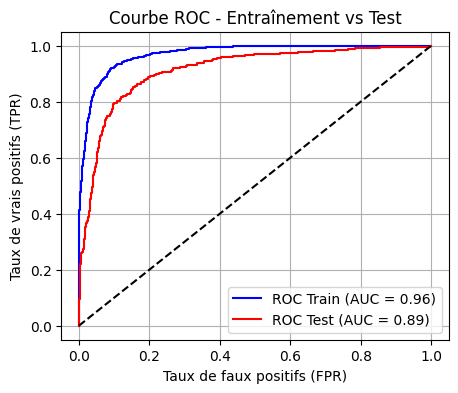

In [32]:
# Tracer les courbes ROC avec les AUC dans la légende
plt.figure(figsize=(5, 4))
plt.plot(train_fpr, train_tpr, color='blue', label=f'ROC Train (AUC = {train_auc_final:.2f})')
plt.plot(test_fpr, test_tpr, color='red', label=f'ROC Test (AUC = {test_auc_final:.2f})')

# Tracer la diagonale de référence (modèle aléatoire)
plt.plot([0, 1], [0, 1], 'k--')

# Ajouter des labels et un titre
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC - Entraînement vs Test')

# Ajouter la légende
plt.legend()
plt.grid()

# Afficher le graphique
plt.show()

In [33]:
gini_test=np.round(2*roc_auc_score(y_test, final_model.predict_proba(X_test_final)[:, 1])-1,2)
gini_test

0.79

In [34]:
# Calculer le log loss sur les ensembles d'entraînement et de test
train_log_loss_final = log_loss(y_train, final_model.predict_proba(X_train_final)[:, 1])
test_log_loss_final = log_loss(y_test, final_model.predict_proba(X_test_final)[:, 1])

# Afficher les résultats du log loss
print(f'Log Loss - Entraînement: {train_log_loss_final:.4f}')
print(f'Log Loss - Test: {test_log_loss_final:.4f}')

Log Loss - Entraînement: 0.2871
Log Loss - Test: 0.3579


* Analyse d'importance des caractéristiques avec SHAP : juste pour le modele random forest optimisé avec grid search

In [35]:
explainer_final = shap.TreeExplainer(final_model) 

# Calculer les valeurs SHAP pour l'ensemble de test avec les 6 variables sélectionnées
shap_values_final = explainer_final.shap_values(X_test_final)

In [36]:
# Vérifier les formes des données
print(f"Forme de X_test_final: {X_test_final.shape}")
print(f"Forme des shap_values_final: {shap_values_final.shape}")

Forme de X_test_final: (1788, 6)
Forme des shap_values_final: (1788, 6, 2)


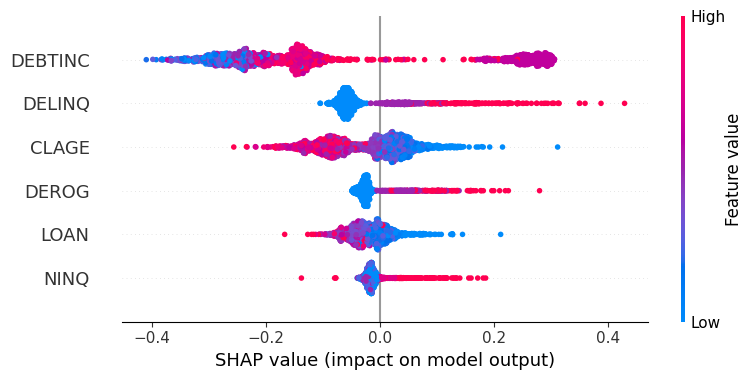

In [37]:
# les shap_values pour la classe 1
shap_values_class_1 = shap_values_final[:, :, 1]

# Résumé de l'importance des features avec SHAP pour la classe 1
shap.summary_plot(shap_values_class_1, X_test_final, feature_names=selected_features)

Commentaire :

La logique derrière ces variables est conforme aux pratiques de gestion du risque de crédit car des individus avec un endettement élevé, un historique de délinquance, et un crédit plus récent (âge de crédit plus court) présentent un risque accru de défaut.

# Conclusion : 

Ce modèle final présente des performances globales satisfaisantes, en particulier en termes de séparation des classes (AUC) et de détection des cas positifs (rappel). Le compromis entre précision et rappel est géré de manière satisfaisante, bien que la précision puisse encore être légèrement améliorée si l'objectif est de minimiser les faux positifs.

Toutefois, le Log Loss suggère que le modèle pourrait continuer d'être amélioré en ce qui concerne la calibration des probabilités.En effet, avec un Log Loss de 0.3579 sur l'ensemble de test, le modèle prédit des probabilités qui sont parfois éloignées des valeurs réelles, suggérant une certaine incertitude ou surestimation dans ses prédictions probabilistes.

Néanmoins, ce modèle constitue une solution robuste pour la détection des défauts de paiement, tout en maintenant un bon équilibre entre complexité (nombre de variables) et performance. Il pourrait être déployé dans un cadre opérationnel, avec des ajustements supplémentaires possibles, notamment pour améliorer le calibrage des probabilités ou ajuster la priorité entre réduction des faux positifs et maximisation du rappel, en fonction des objectifs du projet.

                                                                # FIN 
